## <center>TP3: Practical introduction to Machine Learning Classification (PIMA dataset)<center>

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

### PIMA DATASET

In [3]:
pima = np.load("pima.npz")

x1 = pima["xall"]
y1 = pima["yall"]
varnames1 = pima["varnames"]

print(varnames1)
print(x1.shape)

['Pregnancies' 'Glucose' 'BloodPressure' 'SkinThickness' 'Insulin' 'BMI'
 'DiabetesPedigreeFunction' 'Age']
(709, 8)


The task to solve is to predict whether a person is diabetic given the 8 features printed above: this is a **binary classification**.

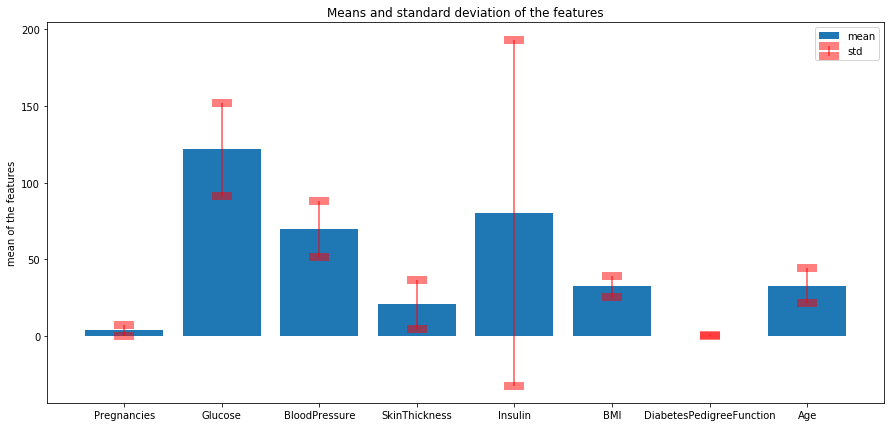

In [12]:
means = np.mean(x1, axis=0)
stds = np.std(x1, axis=0)

fig = plt.figure(figsize=(15,7))

plt.bar(varnames1, means, label="mean")
plt.errorbar(varnames1, means, yerr=stds,
    fmt = "none", capsize = 10, ecolor = "red", elinewidth = 2, capthick = 8, alpha=0.5, label="std")

plt.xticks(varnames1)
plt.ylabel("mean of the features")
plt.title("Means and standard deviation of the features")
plt.legend()
plt.show()

The persons are between 30 and 40 years old in average.

Notice that the magnitudes can radically vary from a feature to another, for instance from DiabetesPedigreeFunction to Glucose, so we will need to rescale them before applying a model.

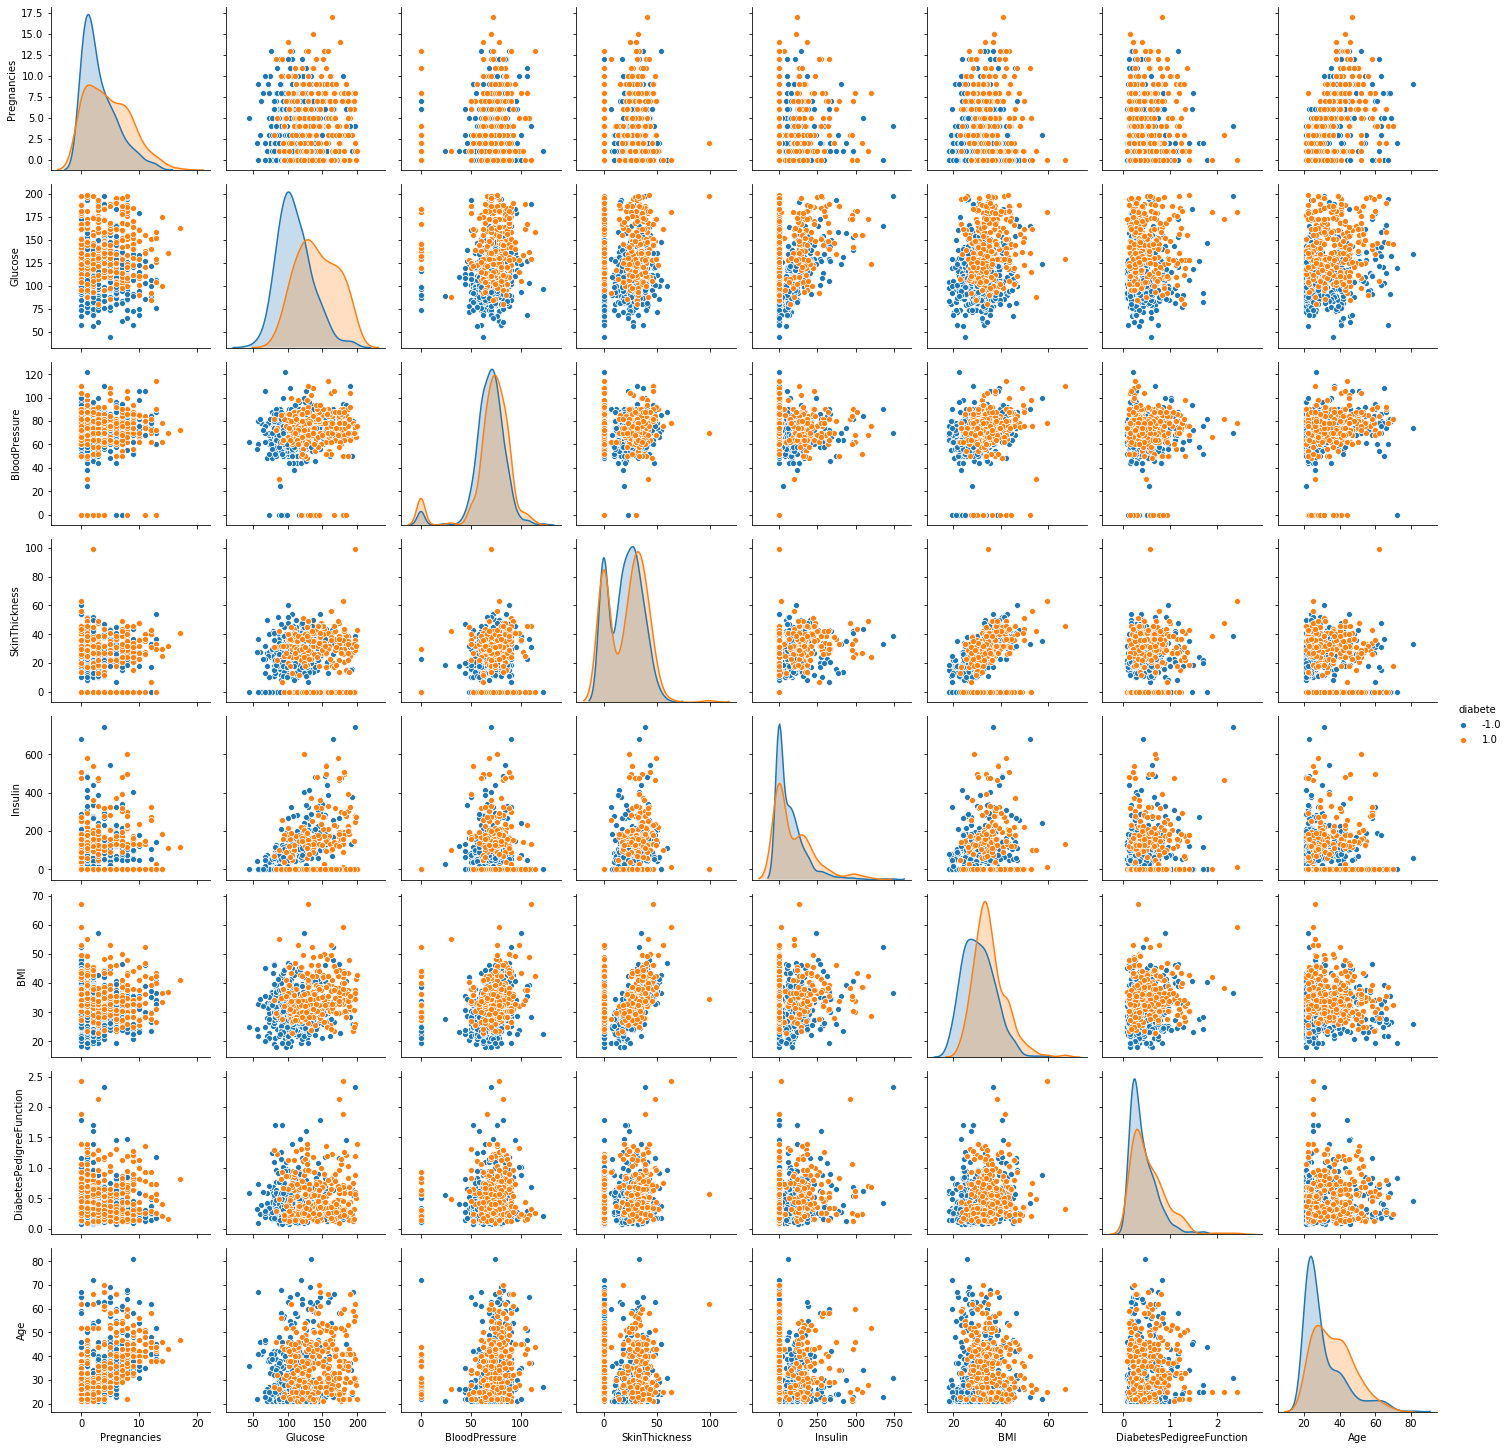

In [53]:
import seaborn as sns

xy1 = np.concatenate((x1,y1.reshape(n1,1)),axis=1)
x1_df = pd.DataFrame(xy1, columns=np.append(varnames1,"diabete"))

x1_df.head()
sns.pairplot(x1_df, hue="diabete")
plt.show()

- According to the histograms on the diagonal of the paiplot, the glucose feature seem to play a key role in this problem since the glucose distributions of diabetic (orange curves) and non diabetic (blue curves) samples are easily distinguisable (in particular, it is striking that they don't have the same means).


- The BMI (Body Mass Index) might have an interesting feature for this binary classification as well: the BMI histogram shows 2 gaussians that have relatively different means, so that it helps separating the classes.


- The pairplot enables to vizualise the relations between couples of features: for instance, Glucose and BMI seem to be linearly related because the cloud of dots is diagonal, but there is apparently no relationship at all between Glucose and SkinThickness features since the cloud of dots is vertical.

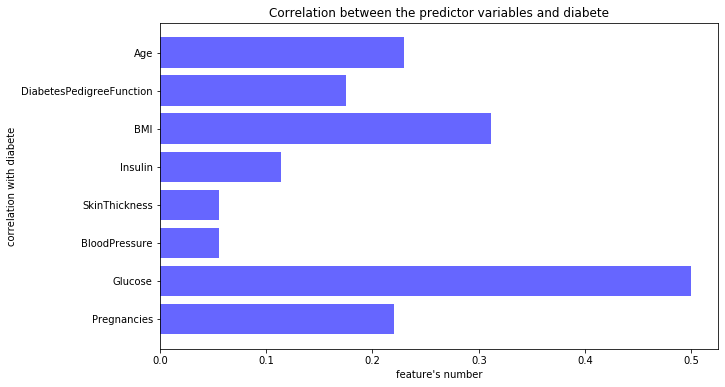

In [236]:
corr_with_diabete = []

for i in range(p1):
    # a voir
    corr_with_diabete.append(np.corrcoef(y1,x1[:,i])[0,1])

fig = plt.figure(figsize=(10,6))
plt.barh(varnames1, corr_with_diabete, color="blue", alpha=0.6)
plt.xlabel("feature's number")
plt.ylabel("correlation with diabete")
plt.title("Correlation between the predictor variables and diabete")
plt.show()

As expected, Glucose has the highest correlation with the target value, followed by BMI, meaning that the diabete is (relatively) $\textit{linearly}$ related to glucose and BMI. Therefore, we expect the linear models to mainly weight those 2 features.

Since the correlations doesn't explain non-linear relations, non-linear models we will apply later might potentially focus on other features too.
 
### Split the data

Let's 300 samples for training set and leave the rest for testing set:

In [14]:
from sklearn.model_selection import train_test_split

x1_train, x1_test, y1_train, y1_test = train_test_split(x1,y1, train_size=300, random_state=0)
print(x1_train.shape)
print(x1_test.shape)

(300, 8)
(409, 8)


### Preprocessing 

As announced earlier, we need to rescale the features because they don't share the same variances/scaling.

If we did not standardize them:

- the coefficients of the linear models would not be interpretable since each weight would also depend on the magnitude of its corresponding feature, not only the importance of that feature for solving the classification task.


- Regularized methods such as Lasso or Ridge Regressions use penalties based on coefficient sizes, so their weights selection would be directly impacted by the biased magnitudes of the coefficients.


In [23]:
from sklearn.preprocessing import StandardScaler

transf1 = StandardScaler()
transf1.fit(x1_train)
x1_train_transformed = transf1.transform(x1_train)
x1_test_transformed = transf1.transform(x1_test)

print("Means of the features after standardization: {}".format(['%.2f'%m for m in x1_train_transformed.mean(axis=0)]))
print("Standard deviations of the features after standardization: {}", x1_train_transformed.std(axis=0))

Means of the features after standardization: ['0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '-0.00', '0.00']
Standard deviations of the features after standardization: {} [1. 1. 1. 1. 1. 1. 1. 1.]


### Bayesian decision and linear classification

In [27]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis()
lda.fit(x1_train_transformed, y1_train)

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)

In [28]:
def get_model_results_on_test(model, x_test=x1_test_transformed, y_test=y1_test, name=""):
    from sklearn.metrics import roc_auc_score
    from sklearn.metrics import plot_roc_curve
    
    # accuracy
    acc = model.score(x_test, y_test)
    print("accuracy of {}: {}".format(name,acc))
    
    # AUC
    #preds = model.predict(x_test)
    scores = model.predict_proba(x_test)[:,1]

    auc = roc_auc_score(y_test, scores)
    print("AUC of {}: {}".format(name,auc))

    model_disp = plot_roc_curve(model, x_test, y_test)
    plt.title("AUC curve of {}".format(name))
    plt.show()
    return acc, auc


accuracy of default LDA: 0.7775061124694377
AUC of default LDA: 0.8541633242419381


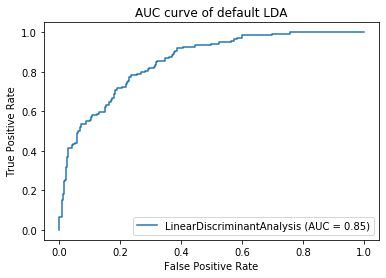

In [29]:
acc_lda, auc_lda = get_model_results_on_test(lda, x_test=x1_test_transformed, y_test=y1_test, name="default LDA")


**Accuracy**

The accuracy metric corresponds to the proportion of correct classifications among the total number of predictions. Hence, an accuracy of $77\%$ means that the model correctly classified almost 8 persons over 10 during the testing process.

The accuracy alone is not enough to conclude whether a model is relevant or not because the testing dataset can be imbalanced: assuming the testing set is composed of 10 testing samples, 8 being non diabetic and 2 being diabetic. Then, even a model always predicting "non diabetic" no matter the features of a sample would reach an accuracy of $80\%$. 

Therefore, we need to rely on additional metrics that takes the following issue into account. The AUC metric is one of them.

**AUC**

In the context of binary classifications, a model's predictions are the probabilities that the tested samples belong to the positive class (here, that the samples are diabetic). By default, if a probability is higher than $\textit{threshold} = 0.5$, then the sample is classified as being diabetic. Otherwise it is not. But the $\textit{threshold}$ can be whatever value between 0 and 1; depending on its value, there will be more or less samples classified as being diabetic.

The AUC is the area under the ROC (Receiver Operating Characteristic) curve, which is drawn by varying this $\textit{threshold}$. The x-axis corresponds to the proportion (among the total number of predictions) of people being classified as diabetic while in reality there are not (False Positive Rate FPR), and the y-axis corresponds to the proportion of people being correctly classified as diabetic (True Positive Rate TPR).

A performant model should lead to high TPRs, and therefore a high AUC: the higher the better for AUC metric.  

**The AUC of default LDA is higher than 0.85, which is a really good result already. By comparison, a model that would randomly classify the samples (resulting in a ROC curve that would correspond to the line FPR=TPR) would lead to an AUC of 0.5 only, so that LDA is far from randomly classifying the persons.**

$\underline{Remark}:$ Unlike the accuracy, the AUC metric may be interesting when the testing dataset has more diabetic (positive class) samples than non diabetic (negative class) samples. Indeed, going back to the last example (10 testing samples with 8 non diabetic and 2 diabetic): TPR=0 and FPR=0, which is characteristic of a model always predicting the negative class, ie when $\textit{threshold}$ is set to 1.


In [30]:
# Create a dataframe to store the values of each model

results_df = pd.DataFrame(data={"accuracy":[acc_lda], "auc":[auc_lda]},
                          index=["default LDA"])
results_df

accuracy       auc
default LDA  0.777506  0.854163

### Find the best shrinkage parameter

Since we now have evidence that AUC is more relevant than accuracy metric, let's try to optimize the AUC score by tuning the $\textit{shrinkage}$ parameter of the LDA, which shrinks the coefficients of the model.

As for the rest of the practical session, we will use sklearn GridSearchCV method and use $\textit{cv}=5$ folds cross-validation to make the outcomes less dependent on the way the dataset has been split. 

The $\textit{shrinkage}$ parameter can be set only for "lsqr" or "eigen" solver, so let's implement 2 grid searches for each type of solver:

#### Solver = "lsqr"

In [31]:
from sklearn.model_selection import GridSearchCV

shrinkages = np.linspace(0,1,200)
#print(shrinkages)
params_lda = {"shrinkage": shrinkages}

grid_lda = GridSearchCV(LinearDiscriminantAnalysis(solver="lsqr"), params_lda, cv=5, scoring="roc_auc")
grid_lda.fit(x1_train_transformed, y1_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=LinearDiscriminantAnalysis(n_components=None,
                                                  priors=None, shrinkage=None,
                                                  solver='lsqr',
                                                  store_covariance=False,
                                                  tol=0.0001),
             iid='deprecated', n_jobs=None,
             param_grid={'shrinkage': array([0.        , 0.00502513, 0.01005025, 0.01507538, 0.0201005 ,
       0.02512563, 0.03015075, 0.03517588, 0.04020101, 0.04522613,
       0.05025126, 0.05527638, 0....
       0.87939698, 0.88442211, 0.88944724, 0.89447236, 0.89949749,
       0.90452261, 0.90954774, 0.91457286, 0.91959799, 0.92462312,
       0.92964824, 0.93467337, 0.93969849, 0.94472362, 0.94974874,
       0.95477387, 0.95979899, 0.96482412, 0.96984925, 0.97487437,
       0.9798995 , 0.98492462, 0.98994975, 0.99497487, 1.        ])},
             pre_dispat

In [32]:
grid_lda.best_params_

{'shrinkage': 0.3165829145728643}

#### Solver="eigen"

In [33]:
grid_lda_ = GridSearchCV(LinearDiscriminantAnalysis(solver="eigen"), params_lda, cv=5, scoring="roc_auc")
grid_lda_.fit(x1_train_transformed, y1_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=LinearDiscriminantAnalysis(n_components=None,
                                                  priors=None, shrinkage=None,
                                                  solver='eigen',
                                                  store_covariance=False,
                                                  tol=0.0001),
             iid='deprecated', n_jobs=None,
             param_grid={'shrinkage': array([0.        , 0.00502513, 0.01005025, 0.01507538, 0.0201005 ,
       0.02512563, 0.03015075, 0.03517588, 0.04020101, 0.04522613,
       0.05025126, 0.05527638, 0...
       0.87939698, 0.88442211, 0.88944724, 0.89447236, 0.89949749,
       0.90452261, 0.90954774, 0.91457286, 0.91959799, 0.92462312,
       0.92964824, 0.93467337, 0.93969849, 0.94472362, 0.94974874,
       0.95477387, 0.95979899, 0.96482412, 0.96984925, 0.97487437,
       0.9798995 , 0.98492462, 0.98994975, 0.99497487, 1.        ])},
             pre_dispat

In [34]:
grid_lda_.best_params_

{'shrinkage': 0.3165829145728643}

Both solvers agree on the best shrinkage value to use, but which solver leads to the best auc ?

In [35]:
print("AUC with Solver = lsqr and shrinkage=0.3: ", grid_lda.best_score_)
print("AUC with Solver = eigen and shrinkage=0.3: ", grid_lda_.best_score_)

AUC with Solver = lsqr and shrinkage=0.3:  0.8270494505494506
AUC with Solver = eigen and shrinkage=0.3:  0.8270494505494506


We end up with the same AUC, so we can pick indifferently one of them.

accuracy of best LDA found by GSCV: 0.7677261613691931
AUC of best LDA found by GSCV: 0.8500454569763088


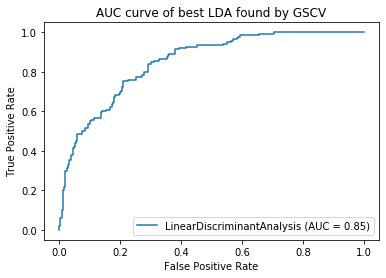

In [36]:
acc_lda_grid, auc_lda_grid = get_model_results_on_test(grid_lda.best_estimator_, x_test=x1_test_transformed, y_test=y1_test, name="best LDA found by GSCV")


Unfortunately, its performances are slightly poorer than the default LDA without shrinkage, so we should not shrink the coefficients.  

By the way, as LDA is a linear model, we can interpret its weights. Let's compare the weights of the default LDA and the shrinked one:

In [47]:
def plot_linear_coef(coeffs, features_names, model_name=""):
    
    fig = plt.figure(figsize=(10,6))
    
    plt.barh(features_names, coeffs, color="green", alpha=0.7)
    plt.title("Coefficients of {}".format(model_name))
    plt.show()

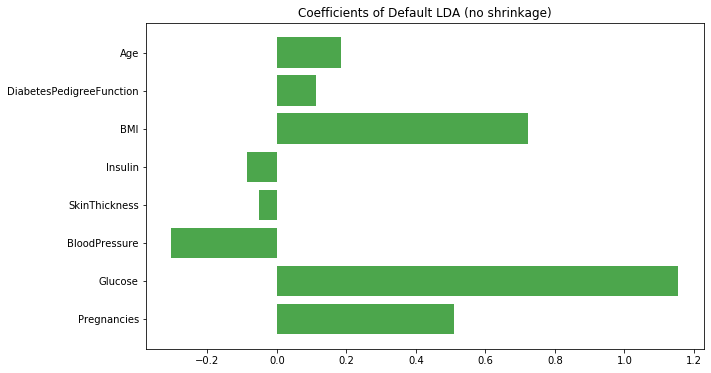

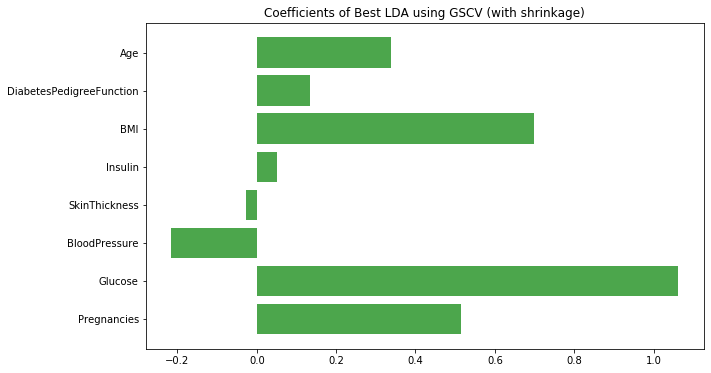

In [49]:
plot_linear_coef(lda.coef_[0], features_names=varnames1, model_name="Default LDA (no shrinkage)")
plot_linear_coef(grid_lda.best_estimator_.coef_[0], features_names=varnames1, model_name="Best LDA using GSCV (with shrinkage)")


Notice that indeed, the coefficients'magnitudes have been slightly shrinked after the grid search.

In both cases, they focus the most on the Glucose and the BMI features, as it was expected from linear models (see the analysis of the correlations between the target value and the features). Their associated weights are positive, which makes sense:

- Glucose is a type of sugar, and since diabetes are caused by an excess of sugar in the blood, the higher the concentration of glucose measured in the blood, the more likely this person is to be diabetic.


- Similarly, measuring a high value for BMI (Body Mass Index) means that the person is obese, therefore, it is very likely that his diet is inappropriate and contains too much sugar. As a consequence, BMI positively increases the probability of being diabetic. 

Let's also try to analyze the other features:

- The Pregnancies feature is also (positively) taken into account. After some research, it appears that there is a phenomenon called gestational diabetes which can eventually happen when a woman is pregnant, so the higher the number of pregnancies, the higher the probability that this phenomenon happened. This is why this information accounts for the model's predictions.

- The weight of BloodPressure is negative: according to my research, lower blood pressure may be a consequence of diabete, ie they are generally negatively correlated. But it appears that there are various types of diabetes, and not all of them results in a diminution of the blood pressure, so that we probably deal with a specific kind of diabete in this practical session.


- The model also focuses on the age feature. Its weight is positive, and I guess this is because this feature might be related to the BMI.


In [39]:
results_df.loc["Best LDA using GSCV",] = [acc_lda_grid, auc_lda_grid]
results_df

accuracy       auc
default LDA          0.777506  0.854163
Best LDA using GSCV  0.767726  0.850045

### Quadratic Discriminant Analysis

In [40]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

qda = QuadraticDiscriminantAnalysis()
qda.fit(x1_train_transformed, y1_train)

QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
                              store_covariance=False, tol=0.0001)

accuracy of default QDA: 0.7628361858190709
AUC of default QDA: 0.8185731857318573


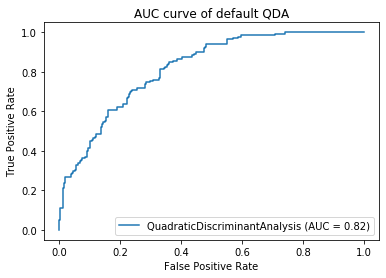

In [41]:
acc_qda, auc_qda = get_model_results_on_test(qda, x_test=x1_test_transformed, y_test=y1_test, name="default QDA")

The AUC score of the default QDA is lower than the LDA's ($0.8185$ vs $0.8541$), so that LDA is a better classifier than the current QDA. 

In [42]:
results_df.loc["default QDA",] = [acc_qda, auc_qda]

results_df

accuracy       auc
default LDA          0.777506  0.854163
Best LDA using GSCV  0.767726  0.850045
default QDA          0.762836  0.818573

Let's try to reach a higher AUC by tuning its $\textit{reg_param}$ parameter:

In [43]:
reg_params = np.linspace(0,1,200)
params_qda = {"reg_param": reg_params}

grid_qda = GridSearchCV(QuadraticDiscriminantAnalysis(), params_qda, cv=5, scoring="roc_auc")
grid_qda.fit(x1_train_transformed, y1_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
                                                     store_covariance=False,
                                                     tol=0.0001),
             iid='deprecated', n_jobs=None,
             param_grid={'reg_param': array([0.        , 0.00502513, 0.01005025, 0.01507538, 0.0201005 ,
       0.02512563, 0.03015075, 0.03517588, 0.04020101, 0.04522613,
       0.05025126, 0.05527638, 0.06030151, 0.06532663, 0.07035176...
       0.87939698, 0.88442211, 0.88944724, 0.89447236, 0.89949749,
       0.90452261, 0.90954774, 0.91457286, 0.91959799, 0.92462312,
       0.92964824, 0.93467337, 0.93969849, 0.94472362, 0.94974874,
       0.95477387, 0.95979899, 0.96482412, 0.96984925, 0.97487437,
       0.9798995 , 0.98492462, 0.98994975, 0.99497487, 1.        ])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=0

In [44]:
grid_qda.best_params_

{'reg_param': 0.5829145728643216}

accuracy of best QDA found by GSCV: 0.7750611246943765
AUC of best QDA found by GSCV: 0.8365420610727847


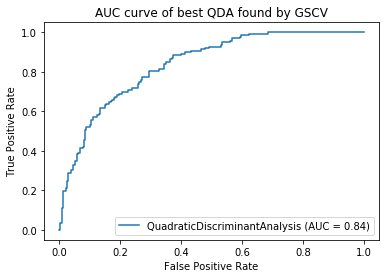

In [45]:
acc_qda_grid, auc_qda_grid = get_model_results_on_test(grid_qda.best_estimator_, x_test=x1_test_transformed, y_test=y1_test, name="best QDA found by GSCV")


At the end, tuning the $\textit{reg_param}$ improved the performances of the Quadratic Discriminant Analysis just a bit: the accuracy raised by $1\%$ only, whereas the AUC score went from $0.818$ to $0.836$, that is to say a relative growth of $2.2\%$.

At the end, the best QDA we could find remains less performant than the (default) LDA (according to both accuracy and AUC metrics).
It might be due to the small number of samples in the training dataset: QDA searches for a covariance matrix per class whereas LDA searches an unique covariance matrix which is shared across both classes. As a consequence, QDA has to find way more parameters ($8\times8=64$ additional parameters than LDA) with just a few samples, which might be more difficult to do/too ambitious.

In [624]:
results_df.loc["best QDA found by GSCV",] = [acc_qda_grid, auc_qda_grid]

results_df

accuracy       auc
default LDA                  0.777506  0.854163
best QDA found by GSCV       0.775061  0.836542
default QDA                  0.762836  0.818573
Gaussian Naive Bayes         0.760391  0.827103
Default logistic Regression  0.777506  0.851730
Best Logit found by GSCV     0.777506  0.852185

### Gaussian Naive Bayes

In [327]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(x1_train_transformed, y1_train)

GaussianNB(priors=None, var_smoothing=1e-09)

accuracy of Naive Bayes: 0.7603911980440098
AUC of Naive Bayes: 0.827103053639232


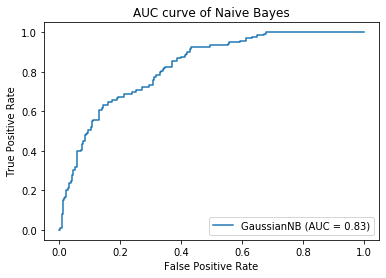

In [328]:
acc_gnb, auc_gnb = get_model_results_on_test(gnb, x_test=x1_test_transformed, y_test=y1_test, name="Naive Bayes")

The AUC of the Gaussian Naive Bayes is lower than the best scores reached by LDA and QDA. It is probably because of the restriction of the independance hypothesis (the features are independant from one another) used by this model. Such an hypothesis is not satisfied here, since there are relationships between the features (for instance between Glucose and BMI). LDA and QDA allows more flexibility by searching for potentially full covariance matrices.

The Gaussian Naive Bayes doesn't admit hyperparameters, so we can't try to improve its performances.

In [600]:
results_df.loc["Gaussian Naive Bayes",] = [acc_gnb,auc_gnb]
results_df

accuracy       auc
default LDA             0.777506  0.854163
best QDA found by GSCV  0.775061  0.836542
default QDA             0.762836  0.818573
Gaussian Naive Bayes    0.760391  0.827103

### Logistic regression

In [52]:
from sklearn.linear_model import LogisticRegression

logit = LogisticRegression(random_state=0)
logit.fit(x1_train_transformed, y1_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

accuracy of Logistic Regression: 0.7775061124694377
AUC of Logistic Regression: 0.8517300390395207


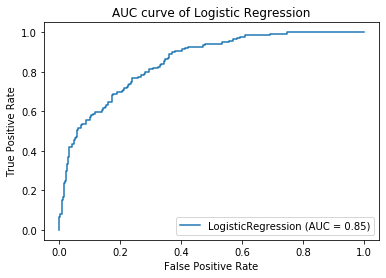

In [53]:
acc_logit, auc_logit = get_model_results_on_test(logit, x_test=x1_test_transformed, y_test=y1_test, name="Logistic Regression")


In [54]:
results_df.loc["Default logistic Regression",] = [acc_logit, auc_logit]
results_df

accuracy       auc
default LDA                  0.777506  0.854163
Best LDA using GSCV          0.767726  0.850045
default QDA                  0.762836  0.818573
Default logistic Regression  0.777506  0.851730

#### Find the best C when using L1 penalization

In [57]:
logit_params = {"C":np.linspace(0.1,1,100), "solver":["liblinear", "saga"]}

grid_logit = GridSearchCV(LogisticRegression(penalty="l1", random_state=0), logit_params, cv=5, scoring="roc_auc")
grid_logit.fit(x1_train_transformed, y1_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l1',
                                          random_state=0, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': array([0.1       , 0.10909091, 0.1181...
       0.78181818, 0.79090909, 0.8       , 0.80909091, 0.81818182,
       0.82727273, 0.83636364, 0.84545455, 0.85454545, 0.86363636,
       0.87272727, 0.88181818, 0.89090909, 0.9       , 0.90909091,
       0.91818182, 0.92727273, 0.93636364, 0.94545455, 0.95454545,
       0.9636363

In [58]:
grid_logit.best_params_

{'C': 0.1272727272727273, 'solver': 'liblinear'}

accuracy of Best Logit found by GSCV: 0.7726161369193154
AUC of Best Logit found by GSCV: 0.8480667415369806


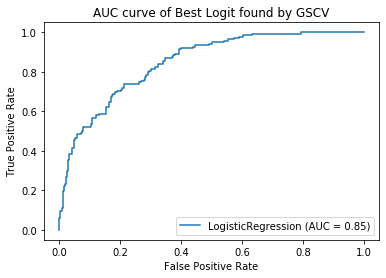

In [59]:
acc_logit_grid, auc_logit_grid = get_model_results_on_test(grid_logit.best_estimator_, x_test=x1_test_transformed, y_test=y1_test, name="Best Logit found by GSCV")


The grid search didn't lead to a better classifier according to AUC and accuracy metrics, but

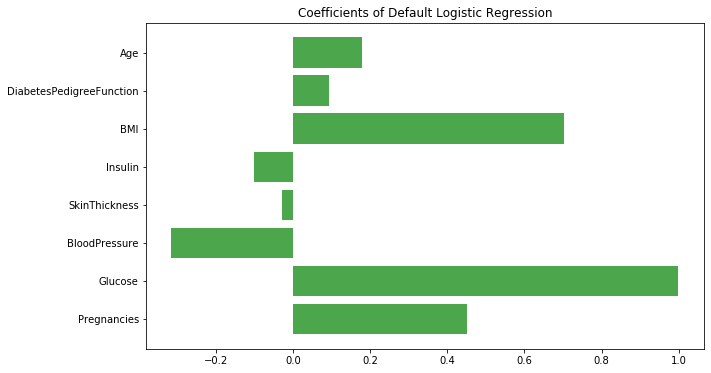

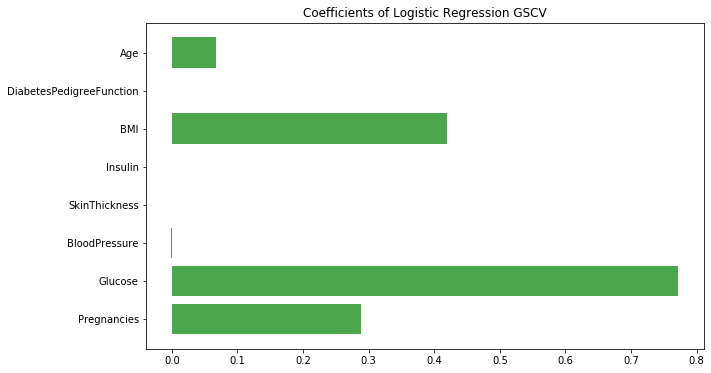

In [630]:
logit_best_grid = grid_logit.best_estimator_

plot_linear_coef(logit.coef_[0], features_names=varnames1, model_name="Default Logistic Regression", dataset="PIMA")

plot_linear_coef(logit_best_grid.coef_[0], features_names=varnames1, model_name="Logistic Regression GSCV", dataset="PIMA")


**Interpretation of the weights**

The regularized model only uses 5 features among 8 (and the BloodPressure is almost not used since its coefficient is almost null): Insulin, SkinThickness and DiabetesPedigreeFunction have been removed by the model.

As for the LDA, the most important features remain the glucose and the BMI. The model also focuses on the "pregnancies" feature. 

Notice that these coefficients are positive: the higher the glucose concentration and the Body Mass Index, the higher the probability of being diabetic.

The number of times a woman has been pregnant ("Pregnancies" feature) can have a consequence on her probability to be diabetic as explained earlier for LDA model.

**Performance of the Regularized Logistic Regression**

Its performances are more or less identical to those of the default logit: 

- its accuracy 0.775061 equals 0.777506 versus for default logistic regression

- its auc 0.846810 equals versus 0.851730 for default logistic regression

Then we end up with (almost) similar performances with a simpler model.

In [631]:
results_df.loc["Best Logit found by GSCV",] = [acc_logit_grid,auc_logit_grid]
results_df

accuracy       auc
default LDA                  0.777506  0.854163
best QDA found by GSCV       0.775061  0.836542
default QDA                  0.762836  0.818573
Gaussian Naive Bayes         0.760391  0.827103
Default logistic Regression  0.777506  0.851730
Best Logit found by GSCV     0.775061  0.846810

### Plot the probabilities distributions

In [375]:
diabete_test_indexes = []
no_diabete_test_indexes = []

for i in range(len(y1_test)):
    if y1_test[i] == 1:
        diabete_test_indexes.append(i)
    else:
        no_diabete_test_indexes.append(i)

print(diabete_test_indexes[:10])

[2, 4, 7, 9, 12, 14, 20, 22, 24, 26]


In [632]:
#scores_lda = lda.predict_proba(x1_test_transformed)[:,1]

def plot_probas_dist(model, model_name="", x_test=x1_test_transformed):
    fig = plt.figure(figsize=(10,6))
    scores = model.predict_proba(x_test)[:,1]
    sns.distplot(scores[diabete_test_indexes], color="blue",
             label="Diabete")
    sns.distplot(scores[no_diabete_test_indexes], color="red",
             label="Non diabete")
    plt.title("Probabilities distribution of {} on testing set".format(model_name))
    plt.legend()
    plt.show()

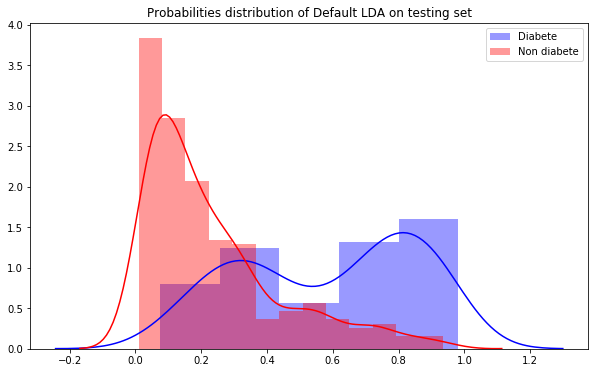

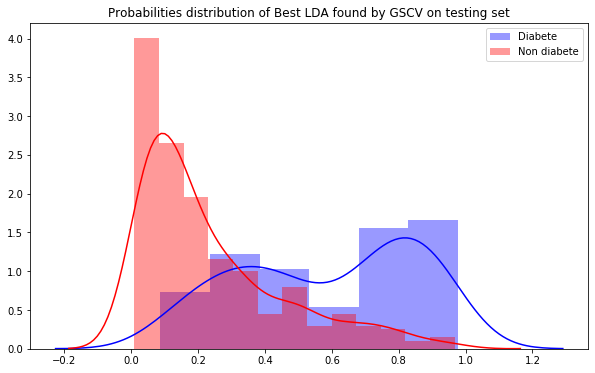

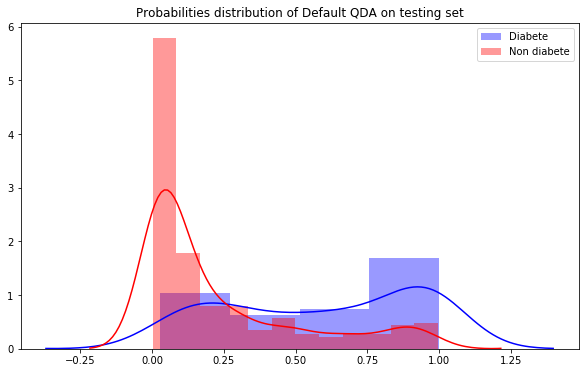

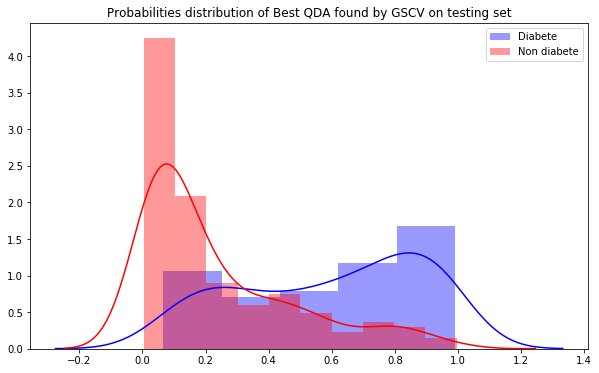

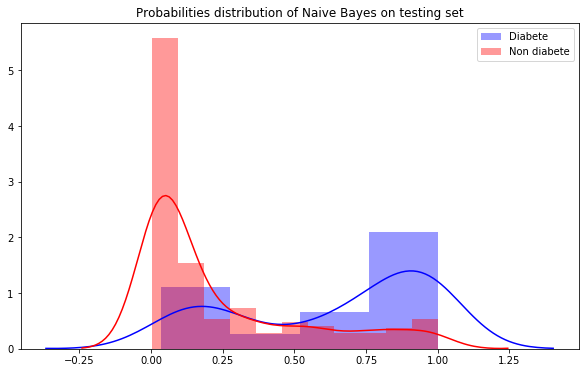

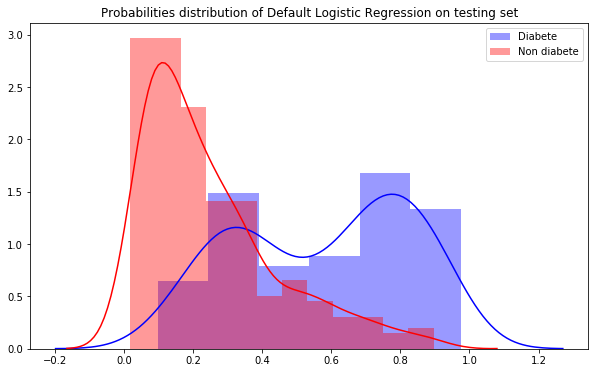

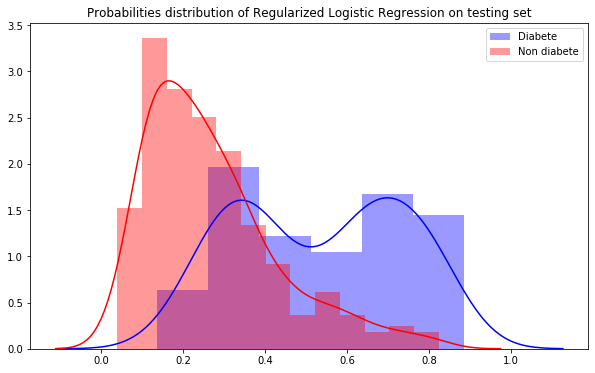

In [633]:
plot_probas_dist(lda, "Default LDA")
plot_probas_dist(grid_lda.best_estimator_, "Best LDA found by GSCV")
plot_probas_dist(qda, "Default QDA")
plot_probas_dist(grid_qda.best_estimator_, "Best QDA found by GSCV")
plot_probas_dist(gnb, "Naive Bayes")
plot_probas_dist(logit, "Default Logistic Regression")
plot_probas_dist(grid_logit.best_estimator_, "Regularized Logistic Regression")

There is quite a lot of overlapping between both classes. 


In fact, the models generally detect correctly a large majority of non diabetic woman, but they struggle much more with diabetic women, as many diabetic women (in blue) are classified as non diabetic (scores lower than 0.5)

It might be due to the imbalanced training dataset: non diabetic women are more common than diabetic ones:

In [611]:
nb_diabetics_train = len(y1_train[y1_train==1])

print("Percentage of diabetic women in training set: {:.2f}".format(nb_diabetics_train/len(y1_train)))

Percentage of diabetic women in training set: 0.35


But it doesn't result from a bad split choice because the proportion of diabetic women is the same in the testing dataset:

In [613]:
nb_diabetics_test = len(y1_test[y1_test==1])

print("Percentage of diabetic women in testing set: {:.2f}".format(nb_diabetics_test/len(y1_test)))

Percentage of diabetic women in testing set: 0.34


Then let's rank the models from best to worse (according to AUC metric):

In [386]:
results_df.sort_values("auc", ascending=False)

accuracy       auc
default LDA                  0.777506  0.854163
Default logistic Regression  0.777506  0.851730
best LDA using GSCV          0.767726  0.850045
Best Logit found by GSCV     0.775061  0.846810
best QDA found by GSCV       0.775061  0.836542
Gaussian Naive Bayes         0.760391  0.827103
default QDA                  0.762836  0.818573

**Best model so far**

According to the results stored in the dataframe results_df, the best model with respect to the AUC metric is the default Linear Discriminant Analysis.

**More generally, it looks like the linear models (LDA and Logistic Regression) performs better on the testing dataset than the quadratic models (QDA and Naive Bayes).**

## Non linear methods

### Random Forest Classifier

In [452]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(random_state=0)
rfc.fit(x1_train_transformed, y1_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

accuracy of Default Random Forest Classifier: 0.7726161369193154
AUC of Default Random Forest Classifier: 0.834095406171453


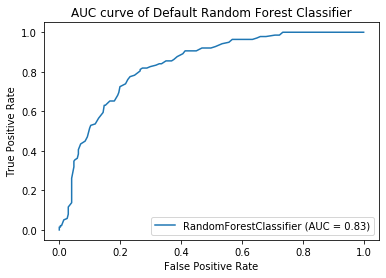

In [453]:
acc_rfc, auc_rfc = get_model_results_on_test(rfc, x_test=x1_test_transformed, y_test=y1_test, name="Default Random Forest Classifier")


Its performances on testing set are reasonable relatively to the other models. 

A Random Forest classifier is an ensemble method which uses a voting system among many Decision Tree classifiers.
The decision frontier of a Random Forest is smoother than the frontiers of a single Decision Tree, but is still segmented/hatched. Therefore, this method is quite limited for our problem since there are linear relations between certain features.

In [634]:
results_df.loc["Default Random Forest",] = [acc_rfc, auc_rfc]

results_df

accuracy       auc
default LDA                  0.777506  0.854163
best QDA found by GSCV       0.775061  0.836542
default QDA                  0.762836  0.818573
Gaussian Naive Bayes         0.760391  0.827103
Default logistic Regression  0.777506  0.851730
Best Logit found by GSCV     0.775061  0.846810
Default Random Forest        0.772616  0.834095

#### Grid Search for the Random Forest Classifier

In [481]:
params_rfc = {"n_estimators": [50,100,150,200, 250],
             "max_depth": [5,10,100],
             "min_samples_leaf":[1,2,3],
             "criterion":["gini","entropy"]}

grid_rfc = GridSearchCV(RandomForestClassifier(random_state=0), params_rfc, cv=5, scoring="roc_auc")
grid_rfc.fit(x1_train_transformed, y1_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=0,
                                   

In [482]:
grid_rfc.best_params_

{'criterion': 'entropy',
 'max_depth': 100,
 'min_samples_leaf': 1,
 'n_estimators': 50}

accuracy of Best Random Forest found by GSCV: 0.7603911980440098
AUC of Best Random Forest found by GSCV: 0.8275977324990641


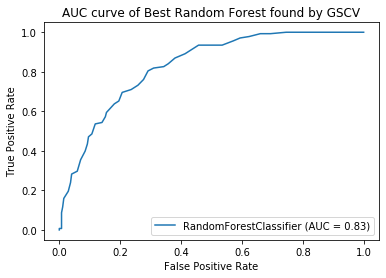

In [619]:
acc_rfc_grid, auc_rfc_grid = get_model_results_on_test(grid_rfc.best_estimator_, x_test=x1_test_transformed, y_test=y1_test, name="Best Random Forest found by GSCV")


The current AUC is lower than the default Random Forest's. In fact, the grid search recommand to use $\textit{max_depth}=100$, whereas this parameter was set to None by default.

Therefore, it seems that deeper trees work better on this problem. It makes sense since the deeper the trees, the smoother the decision frontiers, which is exactly what we are looking for to model the linear relationships.

In [635]:
results_df.loc["Best Random Forest found by GSCV",] = [acc_rfc_grid, auc_rfc_grid]

results_df

accuracy       auc
default LDA                       0.777506  0.854163
best QDA found by GSCV            0.775061  0.836542
default QDA                       0.762836  0.818573
Gaussian Naive Bayes              0.760391  0.827103
Default logistic Regression       0.777506  0.851730
Best Logit found by GSCV          0.775061  0.846810
Default Random Forest             0.772616  0.834095
Best Random Forest found by GSCV  0.760391  0.827598

### SVC

In [472]:
from sklearn.svm import SVC

svc = SVC(probability=True, random_state=0)
svc.fit(x1_train_transformed, y1_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=0, shrinking=True, tol=0.001,
    verbose=False)

accuracy of Default SVC: 0.7750611246943765
AUC of Default SVC: 0.8368896732445584


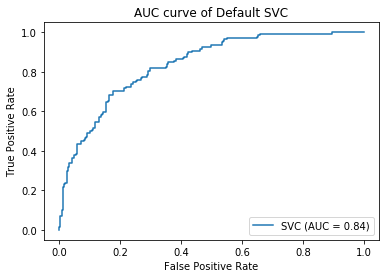

In [636]:
acc_svc, auc_svc = get_model_results_on_test(svc, x_test=x1_test_transformed, y_test=y1_test, name="Default SVC")


In [637]:
results_df.loc["Default SVC",] = [acc_svc, auc_svc]

results_df

accuracy       auc
default LDA                       0.777506  0.854163
best QDA found by GSCV            0.775061  0.836542
default QDA                       0.762836  0.818573
Gaussian Naive Bayes              0.760391  0.827103
Default logistic Regression       0.777506  0.851730
Best Logit found by GSCV          0.775061  0.846810
Default Random Forest             0.772616  0.834095
Best Random Forest found by GSCV  0.760391  0.827598
Default SVC                       0.775061  0.836890

#### Grid Search for SVC

In [463]:
params_svc = {"kernel": ["rbf","linear","sigmoid", "poly"],
             "C": [10**i for i in range(-2,3)]}

grid_svc = GridSearchCV(SVC(probability=True, random_state=0), params_svc, cv=5, scoring="roc_auc")
grid_svc.fit(x1_train_transformed, y1_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=True, random_state=0, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.01, 0.1, 1, 10, 100],
                         'kernel': ['rbf', 'linear', 'sigmoid', 'poly']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=0)

In [464]:
grid_svc.best_params_

{'C': 1, 'kernel': 'rbf'}

These are actually the default parameters.

### MLP Classifier

Neural networks need large amount of data to perform well, so we won't be able to take full advantage of this state-of-the-art method since the training dataset is small (300 samples only).

In [430]:
from sklearn.neural_network import MLPClassifier
import warnings
warnings.filterwarnings("ignore")

mlp = MLPClassifier(random_state=0)
mlp.fit(x1_train_transformed, y1_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=0, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

accuracy of Default MLP: 0.7677261613691931
AUC of Default MLP: 0.8275041446066634


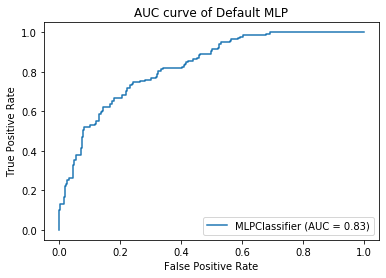

In [432]:
acc_mlp, auc_mlp = get_model_results_on_test(mlp, x_test=x1_test_transformed, y_test=y1_test, name="Default MLP")


The AUC of the default MLP is medium: it is lower than the scores of Logistic Regression and LDA, but still higher than the values of default QDA and Gaussian Naive Bayes.

MLP is a very flexible model, ie it has a large number of hyperparameters that can be chosen. Let's try to find an interesting combinaison below:

In [638]:
results_df.loc["Default MLP",] = [acc_mlp, auc_mlp]

#results_df

accuracy       auc
default LDA                       0.777506  0.854163
best QDA found by GSCV            0.775061  0.836542
default QDA                       0.762836  0.818573
Gaussian Naive Bayes              0.760391  0.827103
Default logistic Regression       0.777506  0.851730
Best Logit found by GSCV          0.775061  0.846810
Default Random Forest             0.772616  0.834095
Best Random Forest found by GSCV  0.760391  0.827598
Default SVC                       0.775061  0.836890
Default MLP                       0.767726  0.827504

#### Tuning the hyperparameters  of MLP

Since a neural networks has too many parameters, we can't afford to search them in a grid for it will run for too long time. Then, let's try to improve the performances of the previous neural network manually:

accuracy of MLP tuned manually: 0.78239608801956
AUC of MLP tuned manually: 0.8538157120701642


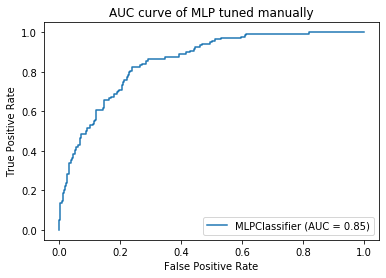

In [447]:
mlp_bis = MLPClassifier(hidden_layer_sizes=(200,100,40),
              learning_rate_init=0.00005, learning_rate="adaptive",
             alpha=0.0003, random_state=0)

mlp_bis.fit(x1_train_transformed, y1_train)
acc_mlp_bis, auc_mlp_bis = get_model_results_on_test(mlp_bis, x_test=x1_test_transformed, y_test=y1_test, name="MLP tuned manually")


The AUC has increased significantly. It is now only surpassed by the score of LDA (the best classifier so far). 

The $\textit{hidden_layer_sizes}$ indicates the structure of the neural network, that is to say how many hidden layers the network has (3 in our case), and the number of neurons in each layer (respectively 200, 100,40).

Setting a value to $\textit{alpha}$ parameter enables a L2 regularization; it helps preventing from overfitting, which may be likely to happen with MLP given their large number of parameters. 

In [639]:
results_df.loc["Best MLP found manually",] = [acc_mlp_bis, auc_mlp_bis]

results_df

accuracy       auc
default LDA                       0.777506  0.854163
best QDA found by GSCV            0.775061  0.836542
default QDA                       0.762836  0.818573
Gaussian Naive Bayes              0.760391  0.827103
Default logistic Regression       0.777506  0.851730
Best Logit found by GSCV          0.775061  0.846810
Default Random Forest             0.772616  0.834095
Best Random Forest found by GSCV  0.760391  0.827598
Default SVC                       0.775061  0.836890
Default MLP                       0.767726  0.827504
Best MLP found manually           0.782396  0.853816

### GradientBoostingClassifier

In [448]:
from sklearn.ensemble import GradientBoostingClassifier

gradient_boosting = GradientBoostingClassifier(random_state=0)
gradient_boosting.fit(x1_train_transformed, y1_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=0, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

accuracy of Default Gradient Boosting: 0.7457212713936431
AUC of Default Gradient Boosting: 0.8158725065511525


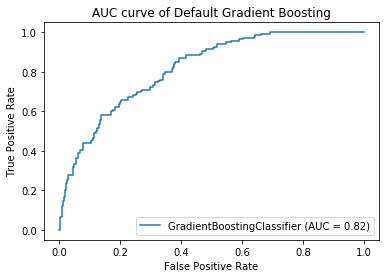

In [640]:
acc_gradient_boosting, auc_gradient_boosting = get_model_results_on_test(gradient_boosting, x_test=x1_test_transformed, y_test=y1_test, name="Default Gradient Boosting")


In [451]:
results_df.loc["Default Gradient Boosting",] = [acc_gradient_boosting, auc_gradient_boosting]

results_df

accuracy       auc
default LDA                  0.777506  0.854163
best LDA using GSCV          0.767726  0.850045
default QDA                  0.762836  0.818573
best QDA found by GSCV       0.775061  0.836542
Gaussian Naive Bayes         0.760391  0.827103
Default logistic Regression  0.777506  0.851730
Best Logit found by GSCV     0.775061  0.846810
Default Random Forest        0.760391  0.837892
Default SVC                  0.775061  0.836890
Default MLP                  0.767726  0.827504
Default Gradient Boosting    0.745721  0.815873

### Grid Search for Gradient Boosting

In [476]:
params_gradient_boosting = {"n_estimators":[10,50,100,150,200],
                           "loss":["deviance","exponential"],
                            "max_depth": [3,4,5,10],
                           "min_samples_leaf":[1,2,3]}

grid_gradient_boosting = GridSearchCV(GradientBoostingClassifier(random_state=0),
                                      params_gradient_boosting, cv=5, scoring="roc_auc")
grid_gradient_boosting.fit(x1_train_transformed, y1_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_c...
                 

In [477]:
grid_gradient_boosting.best_params_

{'loss': 'deviance', 'max_depth': 4, 'min_samples_leaf': 1, 'n_estimators': 50}

accuracy of Best Gradient Boosting found by GSCV: 0.7603911980440098
AUC of Best Gradient Boosting found by GSCV: 0.8206588587625007


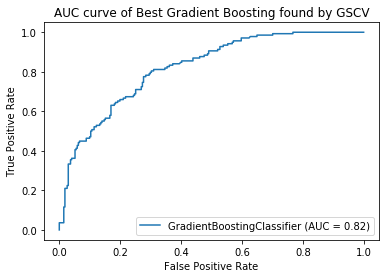

In [641]:
gboost_best_grid = grid_gradient_boosting.best_estimator_
acc_gboost_grid, auc_gboost_grid = get_model_results_on_test(gboost_best_grid,
                                                             x_test=x1_test_transformed, y_test=y1_test, name="Best Gradient Boosting found by GSCV")

In [642]:
results_df.loc["Best Gradient Boost found by GSCV",] = [acc_gboost_grid, auc_gboost_grid]

results_df

accuracy       auc
default LDA                        0.777506  0.854163
best QDA found by GSCV             0.775061  0.836542
default QDA                        0.762836  0.818573
Gaussian Naive Bayes               0.760391  0.827103
Default logistic Regression        0.777506  0.851730
Best Logit found by GSCV           0.775061  0.846810
Default Random Forest              0.772616  0.834095
Best Random Forest found by GSCV   0.760391  0.827598
Default SVC                        0.775061  0.836890
Default MLP                        0.767726  0.827504
Best MLP found manually            0.782396  0.853816
Best Gradient Boost found by GSCV  0.760391  0.820659

### 2.4 Comparison and interpretation

In [643]:
results_df.sort_values("auc", ascending=False)

accuracy       auc
default LDA                        0.777506  0.854163
Best MLP found manually            0.782396  0.853816
Default logistic Regression        0.777506  0.851730
Best Logit found by GSCV           0.775061  0.846810
Default SVC                        0.775061  0.836890
best QDA found by GSCV             0.775061  0.836542
Default Random Forest              0.772616  0.834095
Best Random Forest found by GSCV   0.760391  0.827598
Default MLP                        0.767726  0.827504
Gaussian Naive Bayes               0.760391  0.827103
Best Gradient Boost found by GSCV  0.760391  0.820659
default QDA                        0.762836  0.818573

The best model according to AUC remains the Linear Discriminative Analysis, so **we don't need non-linearity in this problem.**

It is also the best model from a medical perspective because it is linear, hence easily interpretable.

Let's compute its confusion matrix:

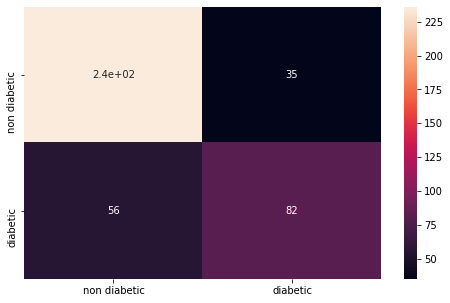

In [63]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

preds_lda = lda.predict(x1_test_transformed)

fig = plt.figure(figsize=(8,5))
conf_mat_lda = confusion_matrix(y1_test, preds_lda)
sns.heatmap(conf_mat_lda, annot=True, xticklabels=["non diabetic","diabetic"],
            yticklabels=["non diabetic","diabetic"])
plt.show()

In [64]:
tn, fp, fn, tp = conf_mat_lda.ravel()

FNR_lda = fn/(fn + tp)
FPR_lda = fp/(fp + tn)

print("False positive rate of LDA:", FPR_lda)
print("False negative rate of LDA:", FNR_lda)

False positive rate of LDA: 0.12915129151291513
False negative rate of LDA: 0.4057971014492754


The FPR is reasonably low ($13\%$), but there are too many false negatives ($40\%$), ie persons declared as being non diabetic while they are. It might be dangerous since these persons, thnking that they are healthy, won't follow any furthur examinations whereas they do need to be treated.

Therefore, the threshold 0.5 is not reached enough times, so we need to increase the intercept value:

In [60]:
initial_intercept = -0.94777565
intercepts = [initial_intercept + 0.05*i for i in range(40)]

In [73]:
fnr_evolution = []
fpr_evolution = []

for b in intercepts:
    lda.intercept_ = b
    preds = lda.predict(x1_test_transformed)
    conf_mat = confusion_matrix(y1_test, preds)
    tn, fp, fn, tp = conf_mat.ravel()
    fnr = fn/(fn+tp)
    fpr = fp/(fp+tn)
    fnr_evolution.append(fnr)
    fpr_evolution.append(fpr)
    print("False negative rate for intercept={:.2f}: {:.2f}".format(b,fnr))

False negative rate for intercept=-0.95: 0.41
False negative rate for intercept=-0.90: 0.41
False negative rate for intercept=-0.85: 0.41
False negative rate for intercept=-0.80: 0.41
False negative rate for intercept=-0.75: 0.37
False negative rate for intercept=-0.70: 0.37
False negative rate for intercept=-0.65: 0.36
False negative rate for intercept=-0.60: 0.36
False negative rate for intercept=-0.55: 0.35
False negative rate for intercept=-0.50: 0.32
False negative rate for intercept=-0.45: 0.29
False negative rate for intercept=-0.40: 0.29
False negative rate for intercept=-0.35: 0.28
False negative rate for intercept=-0.30: 0.28
False negative rate for intercept=-0.25: 0.24
False negative rate for intercept=-0.20: 0.22
False negative rate for intercept=-0.15: 0.22
False negative rate for intercept=-0.10: 0.20
False negative rate for intercept=-0.05: 0.19
False negative rate for intercept=0.00: 0.18
False negative rate for intercept=0.05: 0.17
False negative rate for intercept=0.

Let's use an intercept of $0.30$, leading to a FNR of $0.1$:

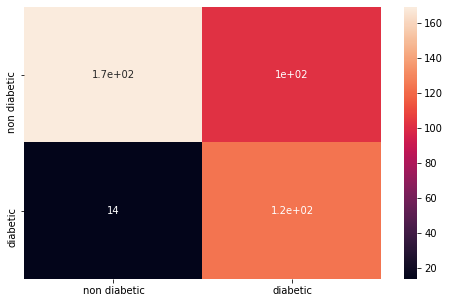

In [69]:
lda.intercept_ = 0.3

preds_lda03 = lda.predict(x1_test_transformed)

fig = plt.figure(figsize=(8,5))
conf_mat03 = confusion_matrix(y1_test, preds_lda03)
sns.heatmap(conf_mat03, annot=True, xticklabels=["non diabetic","diabetic"],
            yticklabels=["non diabetic","diabetic"])
plt.show()

Now the opposite problem happens: too many people are detected as being diabetic while they are not (false positives). Whereas they were 35 of them previously, now their number reaches more than a hundred:

In [71]:
tn03, fp03, fn03, tp03 = conf_mat03.ravel()
print("False positive rate of LDA with intercept=0.3:", fp03/(fp03+tn03))

False positive rate of LDA with intercept=0.3: 0.3763837638376384


But this issue is less worrying since a person declared as diabetic will have to go through posterior examinations, then it will be possible to detect that this result was a mistake.

If we tried to increase the intercept even more to reduce the false negative rate, we would notice that the false positive rate would increase even more, which is not desired: we accept more false positives than false negatives, but still...

Let's vizualise this trade-off:

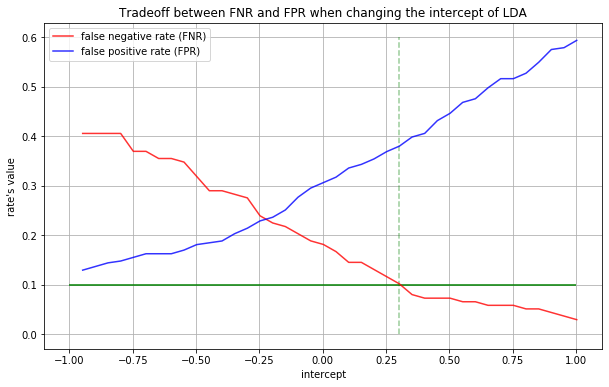

In [74]:
fig = plt.figure(figsize=(10,6))
plt.plot(intercepts, fnr_evolution, label="false negative rate (FNR)", color="red", alpha=0.8)
plt.plot(intercepts, fpr_evolution, label="false positive rate (FPR)", color="blue", alpha=0.8)
plt.xlabel("intercept")
plt.ylabel("rate's value")
plt.title("Tradeoff between FNR and FPR when changing the intercept of LDA")
plt.hlines(0.1, -1, 1, "green")
plt.vlines(0.3, 0, 0.6, "green", alpha=0.4, linestyles="dashed")
plt.legend()
plt.grid(True)
plt.show()

Indeed, the FNR and FPR are negatively correlated. 

As a consequence, I think we should stick to this level of intercept.

### Personnal discussion:

- This practical session has been the opportunity to discover LDA and QDA. I found the first one very interesting for its interpretability, and is looking forward to apply the second one more successfully in another context. It should be performant with more samples.


- By the way, I rediscovered the importance of wisely choosing the metrics to evaluate the performance of ML models. I can imagine how the trade-off to tune between the false positive rate and the false negative rate might lead to discussion with other local experts and laboratories. For instance, it could depend on the region: if it is a priori known that the number of observed cases in a specific area is generally large, then we might want to pay attention to the FNR even more. 


- Since I was lucky enough to have a good split of the dataset (same proportions of diabetic samples in both training and testing sets), I didn't look for further ways of splitting it. I think that a stratitied cross-validation would have been more appropriate just in case, since we are dealing with an imabalance dataset here.


- Once again, this partical session shows how powerful linear models can be.